<a href="https://colab.research.google.com/github/ManuelRuthardt/stock_prediction/blob/master/forecasting_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from datetime import date, timedelta


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')


yesterday = date.today() + timedelta(days=-1)
start = datetime.datetime(2010, 1, 1)
# t-1 as the end date 
end = date.today() + timedelta(days=-1) 

df = web.DataReader("TD.TO", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-09,73.370003,72.849998,73.349998,73.190002,3140000.0,73.190002
2019-09-10,74.029999,73.050003,73.120003,74.010002,2781900.0,74.010002
2019-09-11,74.570000,73.680000,73.900002,74.320000,3438400.0,74.320000
2019-09-12,74.879997,73.870003,74.199997,74.769997,6479900.0,74.769997
2019-09-13,75.410004,74.760002,74.769997,75.209999,4209600.0,75.209999


Model Generation + Feature Engineering

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

import math
import numpy as np


dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-09-09,73.190002,3140000.0,0.710485,-0.218127
2019-09-10,74.010002,2781900.0,1.324140,1.217176
2019-09-11,74.320000,3438400.0,1.197523,0.568333
2019-09-12,74.769997,6479900.0,1.350802,0.768194
2019-09-13,75.209999,4209600.0,0.864249,0.588475


Pre-processing & Cross Validation

In [29]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to forecast 1% of the data set. E.g. we have 2400+ observations
# and will round up to 1% of 2500 which is 25. We will forecast 25days of prices
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]
dfreg.tail(5)

,Adj Close,Volume,HL_PCT,PCT_change,label
Date,,,,,
2019-09-09,73.190002,3140000.0,0.710485,-0.218127,NaN
2019-09-10,74.010002,2781900.0,1.324140,1.217176,NaN
2019-09-11,74.320000,3438400.0,1.197523,0.568333,NaN
2019-09-12,74.769997,6479900.0,1.350802,0.768194,NaN
2019-09-13,75.209999,4209600.0,0.864249,0.588475,NaN


Model Generation

In [30]:
# define the X_train and y_train variable first, this was not done in the original tutorial
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2 - Ridge Poly 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3 - Ridge Poly3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

Evaluation of models

In [31]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results/accuracy
print('The linear regression confidence is ' + str(confidencereg))
print('The ridge polynomial 2 regression confidence is ' + str(confidencepoly2))
print('The ridge polynomial 3 confidence is ' + str(confidencepoly3))
print('The knn regression confidence is ' + str(confidenceknn))

The linear regression confidence is 0.9870466160376552
The ridge polynomial 2 regression confidence is 0.9873378036217499
The ridge polynomial 3 confidence is 0.9884666197898161
The knn regression confidence is 0.9686135095667063


Forecastign and Visualizing

In [0]:

# add a Forecast column filled with NaN for now for each model we will be using.
dfreg['Forecast'] = np.nan


# Forecasting prices with each model
forecast_set_linear = clfreg.predict(X_lately)
forecast_set_ridge2 = clfpoly2.predict(X_lately)
forecast_set_ridge3 = clfpoly3.predict(X_lately)
forecast_set_knn = clfknn.predict(X_lately)

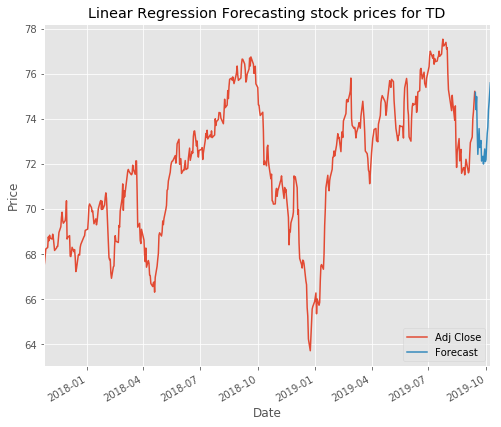

In [33]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_linear:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Linear Regression Forecasting stock prices for TD')
plt.show()

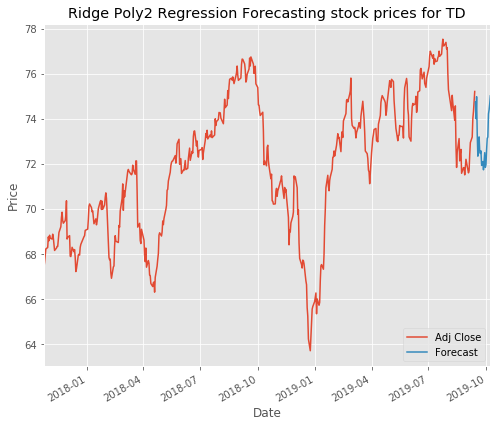

In [34]:

last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_ridge2:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Ridge Poly2 Regression Forecasting stock prices for TD')
plt.show()

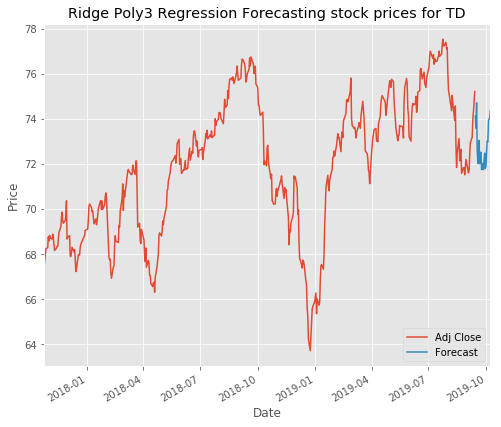

In [35]:
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_ridge3:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Ridge Poly3 Regression Forecasting stock prices for TD')
plt.show()

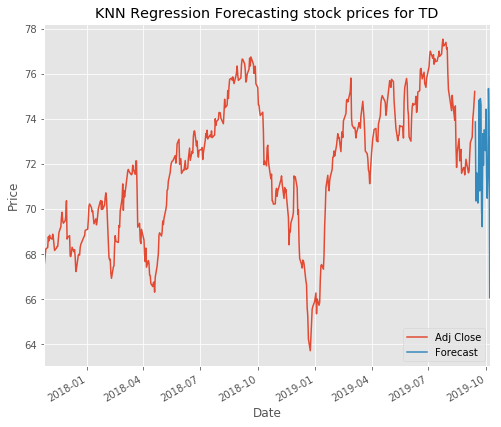

In [36]:
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_knn:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('KNN Regression Forecasting stock prices for TD')
plt.show()